In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Data Initializing**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/skripsi_chandra/ABSA_aspect.csv')
df.head()

,review_token,aspects
0,"[7, 36, 62, 27, 269, 26, 6, 97, 334, 7, 288, 2...","[1, 0, 1, 1]"
1,"[293, 74, 1, 913, 107, 80, 4, 19, 186, 15, 198...","[1, 0, 1, 1]"
2,"[2, 87, 17, 107, 137, 213, 89, 2, 82, 6, 53, 3...","[1, 0, 0, 1]"
3,"[328, 32, 186, 329, 820, 1178, 2402, 326, 2403...","[1, 0, 0, 0]"
4,"[2, 14, 12, 33, 519, 41, 4, 50, 25, 19, 68, 68...","[1, 0, 0, 1]"


In [ ]:
print(type(df['aspects'][0]))
print(type(df['review_token'][0]))

<class 'str'>
<class 'str'>


In [ ]:
import ast

df['aspects'] = df['aspects'].apply(lambda x:ast.literal_eval(x))
df['review_token'] = df['review_token'].map(lambda x: list(map(int, x[1:-1].split(', '))))

In [ ]:
print(type(df['aspects'][0]))
print(type(df['review_token'][0]))

<class 'list'>
<class 'list'>


In [ ]:
import numpy as np

reviews = df[['review_token']]
labels = np.array(df['aspects'].tolist())

## **Splitting Data and Applying Padding**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(7471, 1) (1601, 1) (1601, 1) (7471, 4) (1601, 4) (1601, 4)


In [ ]:
x_train_pad = x_train['review_token']
x_val_pad = x_val['review_token']
x_test_pad = x_test['review_token']

In [ ]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

x_train = pad_sequences(x_train_pad, maxlen=100)
x_val = pad_sequences(x_val_pad, maxlen=100)
x_test = pad_sequences(x_test_pad, maxlen=100)

## **Modeling Initialization**

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
import numpy as np

embedding_matrix = np.load('/content/gdrive/MyDrive/skripsi_chandra/embedding_matrix.npy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(restore_best_weights=True, patience=3,
                               min_delta=0.01, monitor='val_loss')

**Hyperparameter tuning**
1. Filter Size [2], [2,3,4]
3. Dropout Rate [0.25, 0.5]
4. Learning Rate [0.001, 0.0001]

## **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNN(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(4, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNN,
    objective='val_accuracy',
    directory='aspect_CNN',
    project_name='aspect'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 39s]
val_accuracy: 0.7595252990722656

Best val_accuracy So Far: 0.7657713890075684
Total elapsed time: 00h 04m 29s
Results summary
Results in aspect_CNN/aspect
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.7657713890075684

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.7595252990722656

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.7589007019996643

Trial 0006 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.001
Score: 0.7557776570320129

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.7464085221290588

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.7345409393310547

Trial 0002 summary
H

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2,3,4', 'dropout rate': 0.25, 'learning rate': 0.0001}

In [ ]:
model = build_CNN(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val), callbacks=[early_stopping])
model.summary()

Epoch 1/50
117/117 [==============================] - 12s 89ms/step - loss: 2.0103 - accuracy: 0.1616 - val_loss: 1.8210 - val_accuracy: 0.1474
Epoch 2/50
117/117 [==============================] - 4s 33ms/step - loss: 1.6514 - accuracy: 0.1761 - val_loss: 1.4467 - val_accuracy: 0.2861
Epoch 3/50
117/117 [==============================] - 3s 23ms/step - loss: 1.2932 - accuracy: 0.4081 - val_loss: 1.1660 - val_accuracy: 0.4797
Epoch 4/50
117/117 [==============================] - 2s 20ms/step - loss: 1.0486 - accuracy: 0.5493 - val_loss: 0.9657 - val_accuracy: 0.5978
Epoch 5/50
117/117 [==============================] - 1s 11ms/step - loss: 0.8627 - accuracy: 0.6193 - val_loss: 0.8097 - val_accuracy: 0.6277
Epoch 6/50
117/117 [==============================] - 2s 13ms/step - loss: 0.7134 - accuracy: 0.6697 - val_loss: 0.6853 - val_accuracy: 0.6814
Epoch 7/50
117/117 [==============================] - 1s 12ms/step - loss: 0.6019 - accuracy: 0.7034 - val_loss: 0.6048 - val_accuracy: 0.722

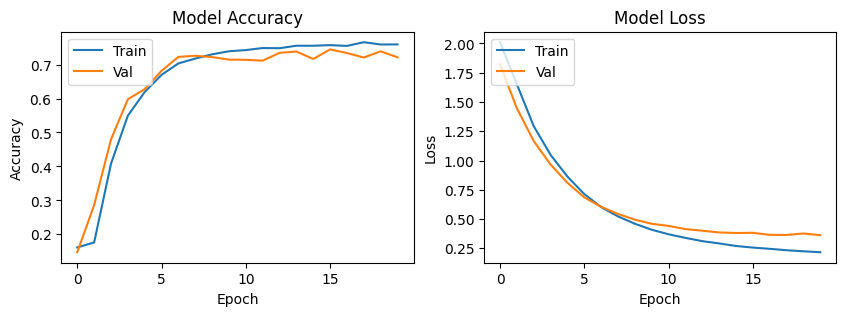

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('aspect_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

51/51 [==============================] - 0s 2ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.8614421028002788
Macro-Average Recall: 0.8341916036086559
Macro-Average F1 Score: 0.8467177822636485


In [ ]:
from sklearn.metrics import classification_report

labels = ['Performance', 'Payment', 'Content', 'Satisfaction']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

 Performance       0.89      0.78      0.84       584
     Payment       0.88      0.85      0.86       465
     Content       0.81      0.85      0.83       424
Satisfaction       0.86      0.85      0.86       976

   micro avg       0.86      0.84      0.85      2449
   macro avg       0.86      0.83      0.85      2449
weighted avg       0.86      0.84      0.85      2449
 samples avg       0.87      0.85      0.84      2449



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


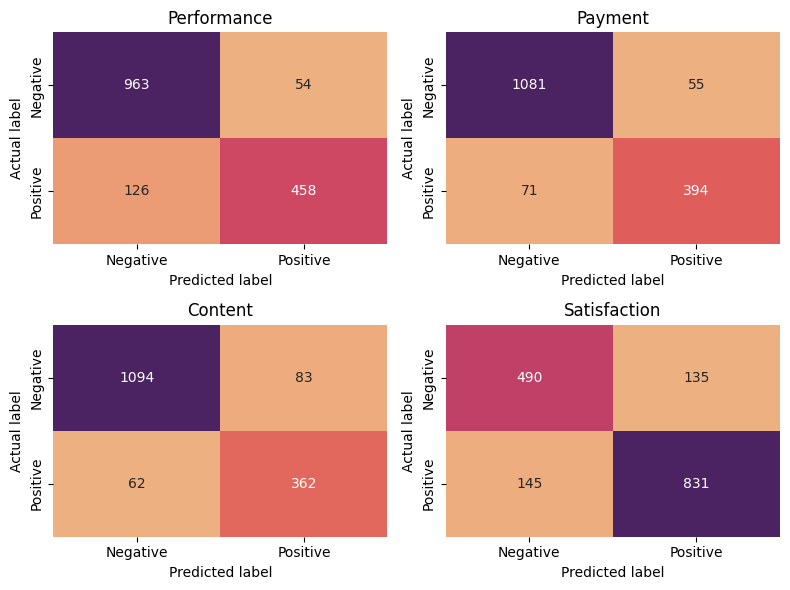

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(mcm[i], annot=True, cmap='flare', fmt='d', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'{label}')
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")

plt.tight_layout()
plt.show()

# **CNN-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout, Activation, MaxPooling1D, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNNLSTM(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(64))
  model.add(Dense(4, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNNLSTM,
    objective='val_accuracy',
    directory='aspect_CNNLSTM',
    project_name='aspect'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 53s]
val_accuracy: 0.7738913297653198

Best val_accuracy So Far: 0.7895065546035767
Total elapsed time: 00h 05m 17s
Results summary
Results in aspect_CNNLSTM/aspect
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0004 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.001
Score: 0.7895065546035767

Trial 0002 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.001
Score: 0.7838850617408752

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.7757651209831238

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.7738913297653198

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.7682698369026184

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.767020583152771

Trial 0006 summary

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2,3,4', 'dropout rate': 0.25, 'learning rate': 0.001}

In [ ]:
model = build_CNNLSTM(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val), callbacks=[early_stopping])
model.summary()

Epoch 1/50
117/117 [==============================] - 13s 82ms/step - loss: 1.0262 - accuracy: 0.4088 - val_loss: 0.4206 - val_accuracy: 0.6996
Epoch 2/50
117/117 [==============================] - 4s 35ms/step - loss: 0.3274 - accuracy: 0.7387 - val_loss: 0.2912 - val_accuracy: 0.7683
Epoch 3/50
117/117 [==============================] - 3s 23ms/step - loss: 0.2343 - accuracy: 0.7599 - val_loss: 0.2620 - val_accuracy: 0.7533
Epoch 4/50
117/117 [==============================] - 3s 23ms/step - loss: 0.1988 - accuracy: 0.7576 - val_loss: 0.2734 - val_accuracy: 0.7908
Epoch 5/50
117/117 [==============================] - 2s 18ms/step - loss: 0.1766 - accuracy: 0.7670 - val_loss: 0.2656 - val_accuracy: 0.7152
Epoch 6/50
117/117 [==============================] - 2s 17ms/step - loss: 0.1593 - accuracy: 0.7794 - val_loss: 0.2729 - val_accuracy: 0.7527
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape            

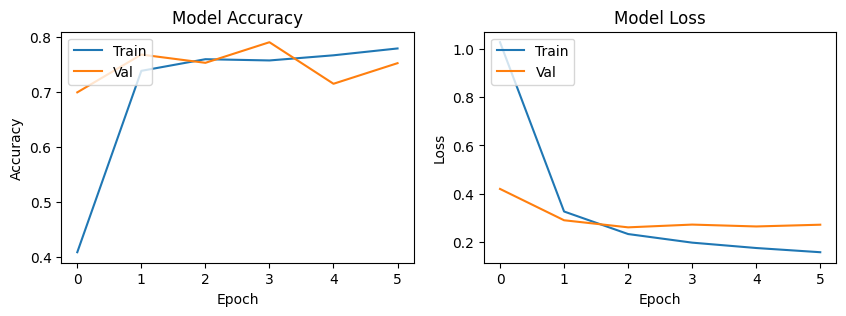

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('aspect_CNNLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

51/51 [==============================] - 1s 3ms/step


In [ ]:
y_pred = predictions > 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.8722881070276971
Macro-Average Recall: 0.8558052324139087
Macro-Average F1 Score: 0.8625602361315912


In [ ]:
from sklearn.metrics import classification_report

labels = ['Performance', 'Payment', 'Content', 'Satisfaction']
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

 Performance       0.91      0.80      0.85       584
     Payment       0.90      0.86      0.88       465
     Content       0.80      0.89      0.85       424
Satisfaction       0.88      0.87      0.87       976

   micro avg       0.87      0.86      0.86      2449
   macro avg       0.87      0.86      0.86      2449
weighted avg       0.88      0.86      0.86      2449
 samples avg       0.88      0.87      0.86      2449



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


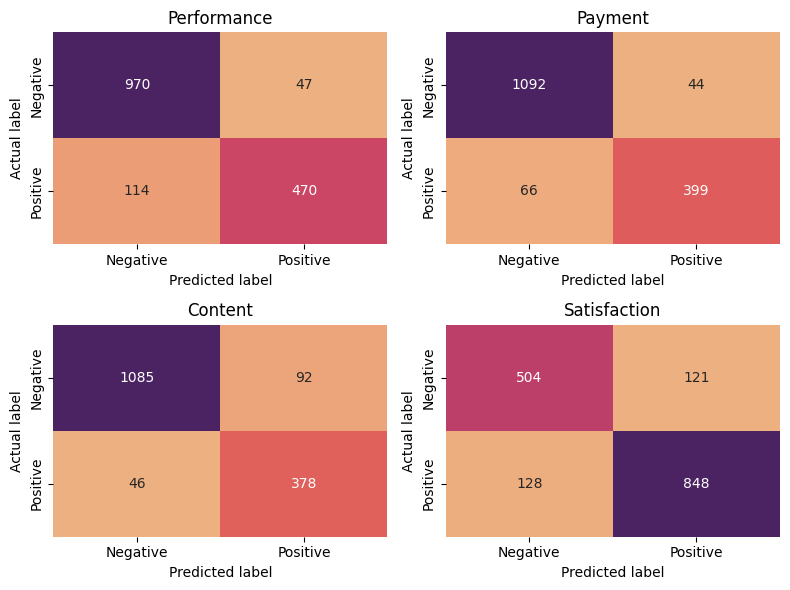

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(mcm[i], annot=True, cmap='flare', fmt='d', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'{label}')
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")

plt.tight_layout()
plt.show()